In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'
import pylab as plb
plb.rcParams['pdf.fonttype'] = 42
recalc_meds = False #recalculate the groupwise median stats set to False to load from file

Populating the interactive namespace from numpy and matplotlib


In [2]:
import h5py
epoch_db = h5py.File('../imaging_post_processing/epoch_db.hdf5','a')

In [3]:
data = dict()
data['exp_names'] = np.array(epoch_db['exp_names'])
data['fly_numbers'] = np.array(epoch_db['fly_numbers'])
data['genotypes'] = np.array(epoch_db['genotypes'])
data['signal_data'] = np.array(epoch_db['signal_data'])
data['signal_names'] = np.array(epoch_db['signal_names'])
data['trial_names'] = np.array(epoch_db['trial_names'])

In [4]:
def fly_medians(data,mask):
    xi = np.linspace(0,23,1150)
    baseline_epoch = (xi >5) & (xi < 7)
    ave_dict = dict()
    signal_set = set(data['signal_names'][mask])
    trial_set = set(data['trial_names'][mask])
    fly_set = set(data['fly_numbers'][mask])
    for signal in signal_set:
        ave_dict[signal] = dict()
        for trial in trial_set:
            ave_dict[signal][trial] = list()
            for fly in fly_set:
                selection = (data['fly_numbers'] == fly) & \
                            (data['signal_names'] == signal) & \
                            (data['trial_names'] == trial) & \
                            mask
                datamtrx = data['signal_data'][selection,:] 
                baseline = np.mean(data['signal_data'][selection][:,baseline_epoch],axis = 1)
                datamtrx -= baseline[:,np.newaxis]
                ave_dict[signal][trial].append(np.nanmedian(datamtrx,axis = 0)) 
    return ave_dict

In [5]:
mask = (data['exp_names'] == 'step_ptch_roll_ctrl') | (data['exp_names'] == 'step_ptch_roll')

In [6]:
import cPickle
if recalc_meds:
    cell_dict = fly_medians(data,mask)
    with open('cell_dict.cpkl','wb') as fi: cPickle.dump(cell_dict,fi)
else:
    with open('cell_dict.cpkl','rb') as fi: cell_dict = cPickle.load(fi)

In [7]:
def get_tuning(meds,signal):
    xi = np.linspace(0,23,1150)
    epoch = (xi >7) & (xi<10)
    tcurve = dict()
    for key in meds[signal].keys():
        data = np.array(meds[signal][key])
        me = np.nanpercentile(np.sum(data[:,epoch],axis = 0),50,axis = 0)
        ub = np.nanpercentile(np.sum(data[:,epoch],axis = 0),75,axis = 0)
        lb = np.nanpercentile(np.sum(data[:,epoch],axis = 0),25,axis = 0)
        tcurve[key] = [me,ub,lb]
    return tcurve

In [8]:
def plot_cell(**kwargs):
    fig = kwargs['fig']
    transform = kwargs['transform']
    sig_scale = kwargs['sig_scale']
    sig_start = kwargs['sig_start']
    row_span =  kwargs['row_span']
    row = kwargs['row']
    
    fig.add_subplot(gs[row:row+row_span,col+1])
    gca().set_axis_bgcolor('none')
    ybound = (sig_start,sig_start+sig_scale*(row_span/4.0))
    #print kwargs['signal_name'] + str(ybound[1] - ybound[0])
    clip_on = kwargs['clip_on']
    stats = cell_dict[kwargs['signal_name']][kwargs['trial_name']]
    
    ub = transform(np.nanpercentile(stats,75,axis = 0))
    lb = transform(np.nanpercentile(stats,25,axis = 0))
    me = transform(np.nanpercentile(stats,50,axis = 0))
    times = np.linspace(0,23,len(ub))
    epoch = (times >5) & (times<17)
    fill_between(times[epoch],ub[epoch],lb[epoch],lw =0,alpha = 0.5,clip_on = clip_on,color = 'k')
    plot(times[epoch],me[epoch],lw =0.2,alpha = 1.0,clip_on = clip_on,color = 'k')
    gca().set_ybound(ybound)
    gca().spines['bottom'].set_visible(kwargs['bspine'])
    #gca().spines['left'].set_visible(kwargs['lspine'])
    gca().spines['left'].set_visible(False)
    gca().spines['top'].set_visible(False)
    gca().spines['right'].set_visible(False)
    [x.set_visible(False) for x in plb.gca().get_xticklabels()]
    [y.set_visible(False) for y in plb.gca().get_yticklabels()]#.set_visible(False)
    [x.set_visible(False) for x in plb.gca().get_xticklines()]
    [y.set_visible(False) for y in plb.gca().get_yticklines()]
    #if kwargs['lspine']:gca().set_ylabel(kwargs['axname'])
    if kwargs['tspine']:gca().set_title(kwargs['trial_label'])
    #if kwargs['bspine']:axvspan(10,13,facecolor = 'g',alpha = 0.3,ymax = 20)

In [9]:
sig_plot_args_baseline_subtract = [ 
                  {'signal_name':'wb_frequency',
                   'axname':'freq',
                   'sig_scale':25,
                   'sig_start':-12,   
                   'row':0,'row_span':5,
                   'transform':lambda x:x},
                  {'signal_name':'Ph1',
                   'axname':'rwing \n amp',
                   'sig_scale': 15,
                   'sig_start':-6,      
                   'row':5,
                   'row_span':5,  
                   'transform':lambda x:np.rad2deg(x/5.0)},
                  {'signal_name':'b1',
                   'axname':'b1',
                   'sig_scale':0.5,
                   'sig_start':-0.25,   
                   'row':10,'row_span':5,  
                   'transform':lambda x:x,
                   'sb':True},
                  {'signal_name':'b2',
                   'axname':'b2',
                   'sig_scale':0.5,
                   'sig_start':-0.1, 
                   'row':15,
                   'row_span':2,  
                   'transform':lambda x:x,
                   'sb':True},
                  {'signal_name':'b3',
                   'axname':'b3',
                   'sig_scale':0.5,
                   'sig_start':-0.1,    
                   'row':17,'row_span':2,  
                   'transform':lambda x:x,
                   'sb':True},
                  {'signal_name':'i1',
                   'axname':'i1',
                   'sig_scale':0.5,
                   'sig_start':-0.1,    
                   'row':20,'row_span':2,  
                   'transform':lambda x:x,
                   'sb':True},
                  {'signal_name':'i2',
                   'axname':'i2',
                   'sig_scale':0.5,
                   'sig_start':-0.1,      
                   'row':22,'row_span':3,  
                   'transform':lambda x:x,
                   'sb':True},
                  {'signal_name':'iii1',
                   'axname':'iii1',
                   'sig_scale':0.5,
                   'sig_start':-0.1,     
                   'row':25,'row_span':2,  
                   'transform':lambda x:x,
                   'sb':True},
                  {'signal_name':'iii24',
                   'axname':'iii24',
                   'sig_scale':0.5,
                   'sig_start':-0.2,   
                   'row':27,'row_span':3,  
                   'transform':lambda x:x,
                   'sb':True},
                  {'signal_name':'iii3', 
                   'axname':'iii3',
                   'sig_scale':0.5,
                   'sig_start':-0.25,  
                   'row':29,'row_span':4,  
                   'transform':lambda x:x,
                  'sb':True},
                  {'signal_name':'hg1',
                   'axname':'hg1',
                   'sig_scale':0.5,
                   'sig_start':-0.1,     
                   'row':34,'row_span':4, 
                   'transform':lambda x:x,
                  'sb':True},
                  {'signal_name':'hg2',
                   'axname':'hg2',
                   'sig_scale':0.5,
                   'sig_start':-0.1,   
                   'row':38,'row_span':2, 
                   'transform':lambda x:x,
                  'sb':True},
                  {'signal_name':'hg3',
                   'axname':'hg3',
                   'sig_scale':0.5,
                   'sig_start':-0.1,   
                   'row':45,'row_span':5, 
                   'transform':lambda x:x,
                  'sb':True},
                  {'signal_name':'hg4',
                   'axname':'hg4',
                   'sig_scale':0.5,
                   'sig_start':-0.25,    
                   'row':50,'row_span':3, 
                   'transform':lambda x:x,
                  'sb':True}]

trial_list = ['pth_roll_%s'%(x) for x in range(0,360,30)]#['flow_right','flow_left','ascending','descending','progressive','regressive']
label_list = range(0,360,30)#['leftward \n yaw','rightward \n yaw',
             #'ascending \n translation','descending \n translation',
             #'progressive \n translation','regressive \n translation']
import matplotlib.gridspec as gridspec
#gs = gridspec.GridSpec(53, len(trial_list))
gs = gridspec.GridSpec(len(sig_plot_args_baseline_subtract)*5 , len(trial_list)+4+1)

In [10]:
xi = np.linspace(0,23,1150)
for signal_dict in sig_plot_args_baseline_subtract:
    times = xi#np.linspace(0,23,shape(data_arrays['signal_data'])[1])
    tselect = (times>7) & (times<10)
    signal_name = signal_dict['signal_name']
    selection = (data['signal_names'] == signal_name) & mask
    trnsfm = signal_dict['transform']
    
    datamtrx = data['signal_data'][selection,:]
    baseline_epoch = (xi >5) & (xi < 7)
    baseline = np.mean(data['signal_data'][selection][:,baseline_epoch],axis = 1)
    datamtrx -= baseline[:,np.newaxis]

    upper = np.nanpercentile(trnsfm(datamtrx[:,tselect]),90)
    lower = np.nanpercentile(trnsfm(datamtrx[:,tselect]),10)
    rng = upper-lower
    signal_dict['sig_scale'] = rng
    signal_dict['sig_start'] = lower

In [11]:
sig_plot_args = sig_plot_args_baseline_subtract

fig = figure(figsize = (8,10))
ax_list = list()

def plot_datacdf(kwargs):
    xi = np.linspace(0,23,1150)
    times = xi#np.linspace(0,23,shape(data_arrays['signal_data'])[1])
    tselect = (times>7) & (times<10)
    signal_name = kwargs['signal_name']
    selection = (data['signal_names'] == signal_name) & mask
    trnsfm = kwargs['transform']
    datamtrx = data['signal_data'][selection,:]
    baseline_epoch = (xi >5) & (xi < 7)

    baseline = data['signal_data'][selection][:,baseline_epoch]
    stim = data['signal_data'][selection][:,tselect]

    def cdf(x):
        x = x[isfinite(x)]
        cumfun = cumsum(sort(x.ravel()))/sum(x)
        npnts = shape(x.ravel())[0]
        domain = sort(x.ravel())
        return domain,cumfun

    plot(*cdf(trnsfm(baseline)),color = 'k')
    plot(*cdf(trnsfm(stim)),color = 'b')
    axhspan(0.1,0.9,color = 'k',alpha = 0.15)
    gca().spines['right'].set_visible(False)
    gca().spines['top'].set_visible(False)
    gca().spines['left'].set_visible(False)
    gca().tick_params(right = 'off',left = 'off',top = 'off',bottom = 'on',labelleft = 'off',labelbottom = 'on')
    axis('tight')
    
for cnum in range(12):
    ax_list.append(fig.add_subplot(gs[:,cnum+1]))
    gca().spines['bottom'].set_visible(False)
    gca().spines['left'].set_visible(False)
    gca().spines['top'].set_visible(False)
    gca().spines['right'].set_visible(False)
    [x.set_visible(False) for x in plb.gca().get_xticklabels()]
    [y.set_visible(False) for y in plb.gca().get_yticklabels()]#.set_visible(False)
    [x.set_visible(False) for x in plb.gca().get_xticklines()]
    [y.set_visible(False) for y in plb.gca().get_yticklines()]
    axvspan(7,10,facecolor = 'g',alpha = 0.2,lw =0)

for rownum,kwargs in enumerate(sig_plot_args):
    kwargs['row'] = rownum*5
    kwargs['row_span'] = 5
    for col,trial_tup in enumerate(zip(trial_list,label_list)):
        trial_name,trial_label = trial_tup
        kwargs['trial_name'] = trial_name
        kwargs['trial_label'] = trial_label
        kwargs['clip_on'] = False
        kwargs['lspine'] = col == 0
        kwargs['tspine'] = rownum == 0
        kwargs['bspine'] = rownum == len(sig_plot_args)-1
        kwargs['fig'] = fig
        plot_cell(**kwargs)

for ax in fig.get_axes():
    ax.set_xbound(5,17.0)

for row,kwargs in enumerate(sig_plot_args):
    tc = get_tuning(cell_dict,kwargs['signal_name'])
    m = np.array([tc['pth_roll_%s'%(x)][0] for x in range(0,360,30)])
    u = np.array([tc['pth_roll_%s'%(x)][1] for x in range(0,360,30)])
    l = np.array([tc['pth_roll_%s'%(x)][2] for x in range(0,360,30)])
    fig.add_subplot(gs[row*5:row*5 + 4,len(trial_list)+1:])
    errorbar(range(0,360,30),m,yerr=np.vstack((u-m,m-l)),capsize=0,color = 'k')
    gca().set_xbound(-30,360)
    gca().spines['left'].set_visible(False)
    gca().spines['top'].set_visible(False)
    gca().spines['bottom'].set_visible(False)

    gca().spines['right'].set_position(('outward',10))
    #gca().spines['bottom'].set_position(('outward',10))
    gca().tick_params(left = 'off',right = 'on',top = 'off',bottom = 'off',labelleft = 'off',labelright = 'on',labelbottom = 'off')
    axhline(0,color = 'k')
    yticks(gca().get_yticks()[::2])
    gca().set_axis_bgcolor('none')

fig.add_subplot(gs[:,len(trial_list)+1:])
gca().spines['right'].set_visible(False)
gca().spines['top'].set_visible(False)
gca().spines['left'].set_visible(False)
#gca().spines['bottom'].set_visible(False)
axvspan(0,90,color = 'b',alpha = 0.3)
axvspan(90,180,color = 'r',alpha = 0.3)
axvspan(180,270,color = 'y',alpha = 0.3)
axvspan(270,360,color = 'c',alpha = 0.3)
gca().tick_params(right = 'off',top = 'off',left = 'off',labelleft = 'off')
gca().spines['bottom'].set_position(('outward',10))
gca().set_axis_bgcolor('none')
gca().set_xbound(-30,360)
xticks(range(0,390,60),rotation='vertical')


for rownum,kwargs in enumerate(sig_plot_args):
    fig.add_subplot(gs[rownum*5:rownum*5+3,0])
    plot_datacdf(kwargs)
    xticks([gca().get_xticks()[0],gca().get_xticks()[-1]])
    gca().set_ylabel(kwargs['axname'])
savefig('fig_4.pdf')
#print [gca().get_yticks()[0],gca().get_yticks()[-1]]

/home/psilentp/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:914: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


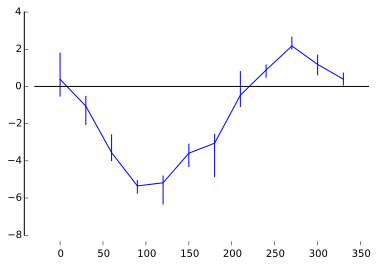

In [13]:
tc = get_tuning(cell_dict,'iii3')
m = np.array([tc['pth_roll_%s'%(x)][0] for x in range(0,360,30)])
u = np.array([tc['pth_roll_%s'%(x)][1] for x in range(0,360,30)])
l = np.array([tc['pth_roll_%s'%(x)][2] for x in range(0,360,30)])
errorbar(range(0,360,30),m,yerr=np.vstack((u-m,m-l)),capsize=0)

gca().set_xbound(-30,360)
gca().spines['right'].set_visible(False)
gca().spines['top'].set_visible(False)
gca().spines['bottom'].set_visible(False)

gca().spines['left'].set_position(('outward',10))
gca().spines['bottom'].set_position(('outward',10))
gca().tick_params(right = 'Off',top = 'Off')

axhline(0,color = 'k')
draw()

In [22]:
angles = arange(0,360,30)
argmax(m)

9